## Introduction

### 1. This notebook will explores building new features from the original text as per follows:
1. Normalizing text with and without stopwords.
2. Reducing TFIDF features in to principle components
3. Estimating statistical measures such as sentence length, pos tag counts and average word length.

These extracted features will be used in building various supervised learning models, and hyper parameter tuning. 

### Some of the models, we intent to try out are: 
1. Threshold model
2. Logistics Regression
3. Support Vector Machine
4. Random Forest 
5. XGBoost
6. Neural Net (Only on above extracted features) 
7. LSTM/GRU using text embedding. 

However, this notebook's goal would only be to extract text features for downstream use.

In [1]:
import spacy
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
tqdm.pandas()
nlp = spacy.load('en_core_web_lg', disable = ['ner', 'parser'])
import nltk
from stop_words import get_stop_words
from nltk.corpus import stopwords
from sklearn.preprocessing import StandardScaler
from collections import Counter
import syllables
import matplotlib.pyplot as plt
%matplotlib inline
import cld2

In [2]:
# Get stopwords:
stopword = list(stopwords.words('english'))
len(stopword)

179

In [3]:
# Get more stopwords: 
stop_word = list(get_stop_words('en'))

In [4]:
# Get all stop words:
stop = stopword+stop_word

In [5]:
# Now, get Dale Text: 
# Find common stopwords between stop and Dale Text: 
df_dale = pd.read_csv('../Dataset/dale_chall.txt').rename(columns = {'a': 'Word'})
len(set(stop).intersection(df_dale['Word'].tolist()))

# The difference between stopwords and dale text approx 50 words which are known to many english learners
# Hence, let's test if removing stopwords impact model accuracy. 

161

In [6]:
# Read Text: 
df_train = pd.read_csv('../Dataset/WikiLarge_Train.csv') 
df_test = pd.read_csv('../Dataset/WikiLarge_Test.csv')


In [7]:
df_train.head()

# Find words which contain -LRB-, -RRB- etc.
#df_train['original_text'].apply(lambda x: [i for i in x.split() if len(i)==3])

,original_text,label
0,There is manuscript evidence that Austen conti...,1
1,"In a remarkable comparative analysis , Mandaea...",1
2,"Before Persephone was released to Hermes , who...",1
3,Cogeneration plants are commonly found in dist...,1
4,"Geneva -LRB- , ; , ; , ; ; -RRB- is the second...",1


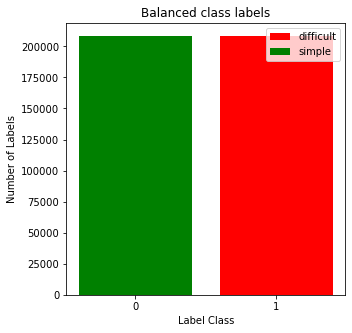

In [8]:
# Count Lables in each class: 
_ = plt.figure(figsize =(5,5))
_ = plt.bar(x = df_train.label.unique()[0], height= df_train.label.value_counts()[0], color = 'red', label = 'difficult')
_ = plt.bar(x = df_train.label.unique()[1], height= df_train.label.value_counts()[1], color = 'green', label = 'simple')
_ = plt.xticks([0,1])
_ = plt.legend(loc = 'best')
_ = plt.title('Balanced class labels')
_ = plt.xlabel('Label Class')
_ = plt.ylabel("Number of Labels")

#### Normalize text

In [9]:
# Pre-process original text: 
# Normalize text:
import re

def normalize_vectorize_pca(df,text, lines = -1, keep_stopwords = True, npca_components=2):
    """Normalizes text in to lower capital letters, removes non-alpha numeric characters,
        digits, new lines, stopwords from the original text"""
    
    # Get stopwords:
    stopword = list(stopwords.words('english'))
    stop_word = list(get_stop_words('en'))
    stop = stopword+stop_word
    
    
    # 1. Normalize text: 
    if keep_stopwords:
        df['norm_text'] = (df[text]
                .progress_apply(lambda x: x.lower())                                 #lower text
                .progress_apply(lambda y: re.sub('[\W+\d+]', " ", y))                #remove non-alpha numeric charcaters
                .progress_apply(lambda z: re.sub('\n',"", z))                        #remove new line
                .progress_apply(lambda d: re.sub('__',"",d))                         #remove double underscore
                .progress_apply(lambda sd: re.sub('_',"",sd))                        #remove single underscore
                .progress_apply(lambda rs: " ".join(rs.split())))                    #remove extra spaces   
        
    
    else: 
        df['norm_text'] = (df[text]
                .progress_apply(lambda x: x.lower())                                 #lower text
                .progress_apply(lambda y: re.sub('[\W+\d+]', " ", y))                #remove non-alpha numeric charcaters
                .progress_apply(lambda z: re.sub('\n',"", z))                        #remove new line
                .progress_apply(lambda d: re.sub('__',"",d))                         #remove double underscore
                .progress_apply(lambda sd: re.sub('_',"",sd))
                .progress_apply(lambda s: [i for i in s.split() if not i in stop])   #remove stopwords
                .progress_apply(lambda j: " ".join(j)))                              #join text                      #remove single underscore
        
    # detect language: en=1, all other languages 0
    df['english'] = np.where(pd.DataFrame([cld2.detect(df['norm_text'][i]) for i in range(0,len(df['norm_text']))])['details']
                                 .progress_apply(lambda x: x[0][1])=='en', 1, 0)

   
    
    # 2. Vectorize text
    
    # keep max_features 2,000
    # select min_df = 1 to avoud unknown words
    # initiate vectorizer: 
    vectorizer  = TfidfVectorizer(max_features=2000, ngram_range=(1,2), min_df=1) #remove unknown words
    
    if lines>=0:
        norm_text = df['norm_text'].values[0:lines]
    else: 
        norm_text = df['norm_text'].values

    # fit transform
    X = vectorizer.fit_transform(norm_text)
    
    # convert vectorized text into dataframe (Use for K-Means clusters)
    df_x_tdif = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names())
    
    
    
    # 3. Reduce TFIDF features X, to 6 Principle components (Assessing impact)
    
    from sklearn.decomposition import PCA
    
    X_pca = PCA(n_components=npca_components).fit_transform(StandardScaler().fit_transform(df_x_tdif))
    
    # convert pca features to dataframe:
    df_xpca = pd.DataFrame(X_pca, columns = ["pca"+str(i) for i in range(1, npca_components+1)])
    
    # concat df_pca features with df
    df_pca = pd.concat([df, df_xpca], axis = 1, ignore_index=False)

    # 4. Return output 
    # df with reduced pca features
    # df with vectorized text
    # vectorizer
    # normalized text
    
    return df_pca, df_x_tdif, vectorizer, norm_text



In [10]:
#%%time (Commented out-long runtime)

# Train
# output
#df_pca_tr, df_x_tdif_tr, vectorizer_tr, norm_text_tr = normalize_vectorize_pca(df_train, 'original_text')
#display(df_pca_tr.head(2), df_x_tdif_tr.head(2), vectorizer_tr, norm_text_tr)

# Test
## output
#df_pca_te, df_x_tdif_te, vectorizer_te, norm_text_te = normalize_vectorize_pca(df_test, 'original_text')
#display(df_pca_te.head(2), df_x_tdif_te.head(2), vectorizer_te, norm_text_te)


# Save TFIDF Train:
#df_x_tdif_tr.to_csv('tfidf_train.csv', index = False)

# Save TFIDF Test:
#df_x_tdif_te.to_csv('tfidf_test.csv', index = False)

#### Pre-process Additional Text Features

In [11]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.tree import DecisionTreeRegressor

def preprocess_additional_features():
    
    """Reads csv file and returns pre-processed
        dataframe of additional features"""

    #df = pd.read_csv(csv_file)
    
    # 1. Read additional features
    
    # age of Acquisition: Approx age when english word was learned.
                            #Important columns "Word", "AoA_Kup_lem", Lemma_highest_PoS
    df_aoa = pd.read_csv('../Dataset/AoA_51715_words.csv', encoding='unicode_escape',
                         usecols = ['Word', 'Lemma_highest_PoS', 'AoA_Kup_lem', 'Nsyll', 'Perc_known', 'Freq_pm']).rename(columns = {'Lemma_highest_PoS': 'lemma'})

    # concreteness rating: Lemma words known to 85% raters
    df_con = pd.read_csv('../Dataset/Concreteness_ratings_Brysbaert_et_al_BRM.txt', sep ='\t').rename(columns = {'Word': 'lemma'})

    # dale chale: Basic english words
    df_dale = pd.read_csv('../Dataset/dale_chall.txt').rename(columns = {'a': 'Word'})
    
    # ASSUMPTION: Basic age of learners who learned 100% of dale chall words is 7 years. 
    df_dale['AoA_Kup_lem'] = 7
    df_dale['Perc_known'] = 1.0
    
    
        
        
    # 2. Merge Files  
    
    # use outer merge to preserve words contained in lemma
    # these words include basic english, concreteness rating of 85% min and AoA.   
    merge_features = (df_con.merge(df_aoa, on = 'lemma', how = 'outer')
                      .merge(df_dale, on = ['Word','AoA_Kup_lem','Perc_known'], how = 'outer'))
    # Filter features: 
    cols = ['lemma', 'Word', 'Nsyll', 'Perc_known', 'AoA_Kup_lem', 'Dom_Pos']

    # selected_features
    select_features  = merge_features[cols]
    
    
    
    
    # 3. Pre-process & treat missing values
    
    # convert dale chall words to nlp object
    select_features['nlp'] = select_features['Word'].progress_apply(lambda x: str(x)).progress_apply(lambda y : nlp(y))

    # get lemma of a word:
    select_features['lemma'] = (select_features['nlp'].progress_apply(lambda x: [text.lemma_ for text in x])
                        .progress_apply(lambda y: " ".join(y))
                        .progress_apply(lambda z: re.sub('[\-PRON-]', '', z)))
    
    # treat missing values: 
    # lemma: some words and lemma are same, hence replace blank lemma's with base words:  
    # get index: 
    fill_lemma_ind = select_features[select_features['lemma']==''].index

    # fill blank lemma where word and lemma is same
    select_features['lemma'].iloc[fill_lemma_ind]= select_features['Word']

    # get POS tags for each Word:
    select_features['pos_tags'] = (select_features['nlp']
                                   .progress_apply(lambda x: [spacy.explain(text.tag_) for text in x])
                                   .progress_apply(lambda y: ",".join(y)).map(lambda z: z.split(',')[0]))
    
    # verify difference between DOM_pos Vs actual pos tags generated by spacy?

    # lower string case in DOM_POS: 
    select_features['Dom_Pos']= select_features['Dom_Pos'].progress_apply(lambda x: str(x).lower())
    select_features[(select_features['Dom_Pos']!=select_features['pos_tags']) & (select_features['Dom_Pos'].notnull()) & (select_features['Dom_Pos']!='0')]

    # Yes, as we can see below DOM_POS is different from spacy generated pos. 
    # Hence, we will use pos_tags instead of Dom_pos.

    select_features['pos'] = (select_features['nlp']
                                   .progress_apply(lambda x: [text.pos_ for text in x])
                                   .progress_apply(lambda y: ",".join(y)).map(lambda z: z.split(',')[0]))
    
    # drop 'Dom_Pos','pos_tags' and nysll (to be estimated using original text):
    features = select_features.drop(columns = ['Dom_Pos','pos_tags', 'Nsyll'], axis = 1)
    
    # check missing values (Commented out): 
    #features.info()
    
    # Initiate imputer to fill missing values: 
    imputer = IterativeImputer(estimator=DecisionTreeRegressor(random_state = 0),
                                add_indicator= True, 
                                random_state= 0)

    # get values: 
    imp = pd.DataFrame(imputer.fit_transform(features[['Perc_known', 'AoA_Kup_lem']]), columns = ['Perc_known', 'AoA_Kup_lem', 'indicator_1', 'indicator_2']).round(2)

    # replace Perc_known and AoA_Kup_lem in features with imputed values: 
    features['Perc_known'] = imp['Perc_known']
    features['AoA_Kup_lem'] = imp['AoA_Kup_lem']

    # verify missing values (Commented out):
    #features.info() 
    
    # alright so this takes care of missing values in additional features
    features = features[features['lemma']!='nan']       
    
    return features

In [12]:
#%%time

# Output
#features = preprocess_additional_features()
#features.head()

# Save pre-processed additional features:
#features.to_csv('additional_features.csv', index = False)

#### Convert Normalized text into Spacy text object

In [13]:
#df_pca, df_x_tdif, vectorizer, norm_text = normalize_vectorize_pca(df_train, 'original_text')

def normed_spacy_textobject(df, text,  keep_stopwords = True, npca_components=2): 
    """Takes in normalied text from normalize_vectorize_pca function
        to convert text in to nlp object"""
    
    # Convert normalized text into spacy nlp object:
    df_pca, df_x_tdif, vectorizer, norm_text = normalize_vectorize_pca(df, 'original_text', keep_stopwords = keep_stopwords, npca_components=npca_components)
   
    # Convert
    df_pca['nlp_norm_text'] = df_pca['norm_text'].progress_apply(lambda x: nlp(x))
    
    return df_pca
    

In [14]:
# Output:
#nlp_norm_train= normed_spacy_textobject(df_train, 'Original_text')
#nlp_norm_test= normed_spacy_textobject(df_test, 'Original_text')


#### Build Text Features

In [15]:
def build_features(df, text, keep_stopwords = True, npca_components=2): 
    
    
    # Dataframe contaning nlp object: 
    df_nlp = normed_spacy_textobject(df, text, keep_stopwords = keep_stopwords, npca_components=npca_components)
   
    
    # 1. Count Lemma's present in both norm text & additional features:
    # get lemma's in norm text:
    df_nlp['lemma'] = df_nlp['nlp_norm_text'].progress_apply(lambda x: [text.lemma_ for text in x])

    # get list of lemmas known to learners above/below 85%:
    features = preprocess_additional_features()
    lemma_85_above = features['lemma'][features['Perc_known']>=0.85].tolist()   #simple text
    lemma_85_below = features['lemma'][features['Perc_known']<0.85].tolist()    #difficult text
    
    # get lemma count >= 85% users: 
    df_nlp['count_lemma_85_above'] = df_nlp['lemma'].progress_apply(lambda x: len(set(x).intersection(lemma_85_above)))
  
    # get lemma count < 85% users: 
    df_nlp['count_lemma_85_below'] = df_nlp['lemma'].progress_apply(lambda x: len(set(x).intersection(lemma_85_below)))



    # 2. Count pos tags present in both norm text & additional features:
    # get POS_tags in norm text: 
    df_nlp['pos'] = df_nlp['nlp_norm_text'].progress_apply(lambda x: [text.pos_ for text in x])
    
    # count how many lemmas exist in each sentence based on additional features:
    check_pos = features['pos'].tolist()

    # get list of unique Pos tags in features: 
    pos_cols = features['pos'].unique()

    # concat count of each POS tag in the norm_text to the dataframe:  
    di = {}
    for i in tqdm(range(0,len(df_nlp['pos']))):
        di[i]= Counter(df_nlp['pos'][i])
    df_pos_counts = pd.DataFrame(di).fillna(0).T

    # concat: 
    df_features = pd.concat([df_nlp, df_pos_counts], axis = 1)
        
        
        
    # 3. Get count of syllables in norm text: 
    df_features['nsyll'] = df_features['norm_text'].progress_apply(lambda x: syllables.estimate(x))
    
    
    
    #4. Calculate sentence length in norm_text: 
    df_features['sent_length'] = df_features['norm_text'].progress_apply(lambda x: len(x.split()))
    
    
    
    #5. Unknown words between norm_text and additonal features: 
    df_features['count_unk'] = df_features['lemma'].progress_apply(lambda x: len(set(x).difference(features['lemma'].tolist())))
    
    # get overall_features where norm_text is not blank
    df_features = df_features[df_features['norm_text'].progress_apply(lambda x: len(x.split()))>0]
    
    
    
    #6. Calculate average length of words in a document: 
    # assumption: Simple sentence average words length would be smaller 

    df_features['avg_wrd_len'] = df_features['norm_text'].progress_apply(lambda x: sum(len(i.split()) for i in x)/len(x.split()))

    _ = plt.figure(figsize = (15,5))
    df_features['avg_wrd_len'][df_nlp['label'] ==0].plot(kind = 'hist', bins = 100, alpha = 0.4, color = 'blue')
    df_features['avg_wrd_len'][df_nlp['label'] ==1].plot(kind = 'hist', bins = 100, alpha = 0.4, color = 'red')
    _ = plt.xlabel('Average Word Length')
    _ = plt.show()      
    
    # Re-arrange df_features into category and numeric columns
    cat_cols = df_features.select_dtypes(['object']).columns
    num_cols = df_features.select_dtypes(['int', 'float']).columns
    
    df_features = df_features[list(cat_cols)+list(num_cols)]
    
    
    return df_features

100%|██████████| 416239/416239 [00:08<00:00, 47985.86it/s]


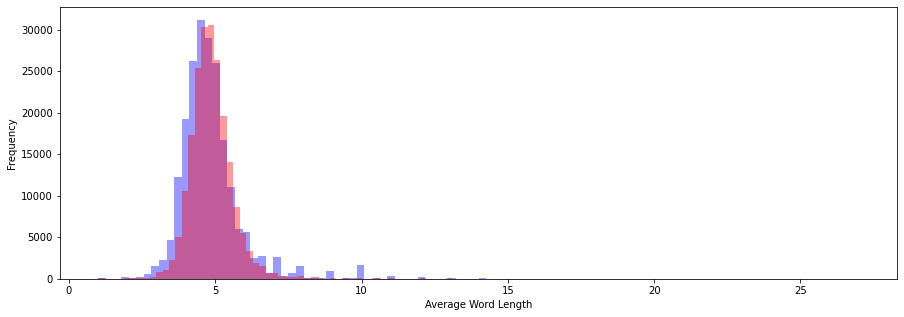

CPU times: user 32min 22s, sys: 34 s, total: 32min 56s
Wall time: 32min 56s


In [16]:
%%time
train_features = build_features(df_train, 'original_text', keep_stopwords = True, npca_components = 6)


100%|██████████| 118928/118928 [00:02<00:00, 48794.84it/s]


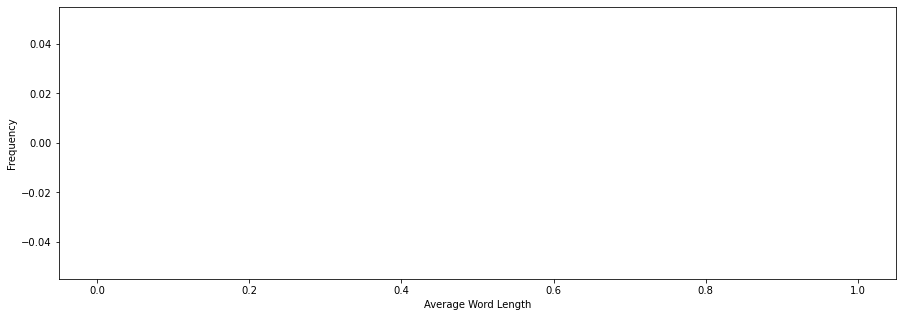

CPU times: user 10min 18s, sys: 9.73 s, total: 10min 27s
Wall time: 10min 27s


In [17]:
%%time
test_features = build_features(df_test, 'original_text', keep_stopwords = True, npca_components= 6)

In [18]:
# Output
display(train_features.head(2), test_features.head(2))

,original_text,norm_text,nlp_norm_text,lemma,pos,label,english,pca1,pca2,pca3,...,CCONJ,ADJ,NUM,X,INTJ,SYM,nsyll,sent_length,count_unk,avg_wrd_len
0,There is manuscript evidence that Austen conti...,there is manuscript evidence that austen conti...,"(there, is, manuscript, evidence, that, austen...","[there, be, manuscript, evidence, that, austen...","[PRON, AUX, NOUN, NOUN, SCONJ, PROPN, VERB, PA...",1,1,-1.24102,0.088704,-0.178737,...,3.0,1.0,0.0,0.0,0.0,0.0,58,35,6,4.485714
1,"In a remarkable comparative analysis , Mandaea...",in a remarkable comparative analysis mandaean ...,"(in, a, remarkable, comparative, analysis, man...","[in, a, remarkable, comparative, analysis, man...","[ADP, DET, ADJ, ADJ, NOUN, PROPN, PROPN, PROPN...",1,1,-0.70978,0.029389,-0.089671,...,0.0,3.0,0.0,0.0,0.0,0.0,45,22,8,5.818182


,original_text,norm_text,nlp_norm_text,lemma,pos,id,label,english,pca1,pca2,...,ADV,NUM,INTJ,X,PUNCT,SYM,nsyll,sent_length,count_unk,avg_wrd_len
16,3-Jun-95,jun,(jun),[jun],[PROPN],16,NaN,0,-0.389192,0.0462,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,3.0
18,14-Feb-02,feb,(feb),[feb],[PROPN],18,NaN,0,-0.389192,0.0462,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,3.0


In [19]:
# Identify what does english label 0 mean in the feature column: 

In [20]:
english_labels = pd.DataFrame([cld2.detect(df_train['norm_text'][i]) for i in range(0,len(df_train['norm_text']))])['details'].apply(lambda x: x[0][0]).unique()

In [21]:
english_1, english_0 = english_labels[0], english_labels[1:]
print('1:', english_1, '\n\n0:', english_0)
# Here, where the english label is 0, the text is more likely to be diffiuclt for native english speakers. 
# Which we will see when we run various models.

1: ENGLISH 

0: ['Unknown' 'MALAY' 'PORTUGUESE' 'GERMAN' 'SWEDISH' 'ROMANIAN' 'SUNDANESE'
 'NORWEGIAN' 'SWAHILI' 'INDONESIAN' 'ITALIAN' 'FRENCH' 'LITHUANIAN'
 'SPANISH' 'GALICIAN' 'CROATIAN' 'DUTCH' 'BASQUE' 'MALAGASY' 'ICELANDIC'
 'UZBEK' 'HAITIAN_CREOLE' 'HUNGARIAN' 'KINYARWANDA' 'GANDA' 'NYANJA'
 'CATALAN' 'POLISH' 'SERBIAN' 'JAVANESE' 'WELSH' 'DANISH' 'AZERBAIJANI'
 'ESTONIAN' 'AFRIKAANS' 'FINNISH' 'KURDISH' 'TAGALOG' 'SESOTHO' 'SLOVAK'
 'LATVIAN' 'CZECH' 'MALTESE' 'TURKISH' 'HMONG' 'CEBUANO' 'SCOTS_GAELIC'
 'BOSNIAN' 'ALBANIAN' 'IRISH' 'VIETNAMESE' 'SLOVENIAN']


In [37]:
# Save train and test features: 
train_features.to_csv('../Dataset/extracted_train_features_with_stopwords_pca.csv', index = False)
test_features.to_csv('../Dataset/extracted_test_features_with_stopwords_pca.csv', index = False)

In [23]:
# Explore english lables: 

In [24]:
df_english_label = df_train.copy()
df_english_label['english'] = pd.DataFrame([cld2.detect(df_english_label['norm_text'][i]) for i in range(0,len(df_english_label['norm_text']))])['details'].apply(lambda x: x[0][0])


In [25]:
df_english_ = df_english_label[['original_text', 'norm_text', 'label', 'english']]

#### Make Plots

In [26]:
import altair as alt
# enable correct rendering (unnecessary in later versions of Altair)
alt.renderers.enable('default')
# uses intermediate json files to speed things up
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

In [27]:
sort_index = df_english_['english'].value_counts()[2:].index.tolist()

In [28]:
non_english_labels = (alt.Chart(df_english_)
                      .mark_circle()
                      .encode(x = alt.X('count(english):Q', title = 'Count'), 
                              size = alt.Size('count(english):Q', scale=alt.Scale(range = [0,500])),
                              y = alt.Y('english:N', title = 'Non English Languages',  sort = sort_index),
                              color = alt.Color('label:N', legend = alt.Legend(title = 'Text Difficulty')),
                              tooltip = ['english', 'label', 'count(english):Q'])
                      .transform_filter(alt.datum.english!='ENGLISH')
                      .transform_filter(alt.datum.english!='Unknown')
                      .properties(width = 300, height = 700)
                      .configure_view(strokeWidth =0)
                      .configure(background = '#f0f0f0'))


In [29]:
non_english_labels 

alt.Chart(...)

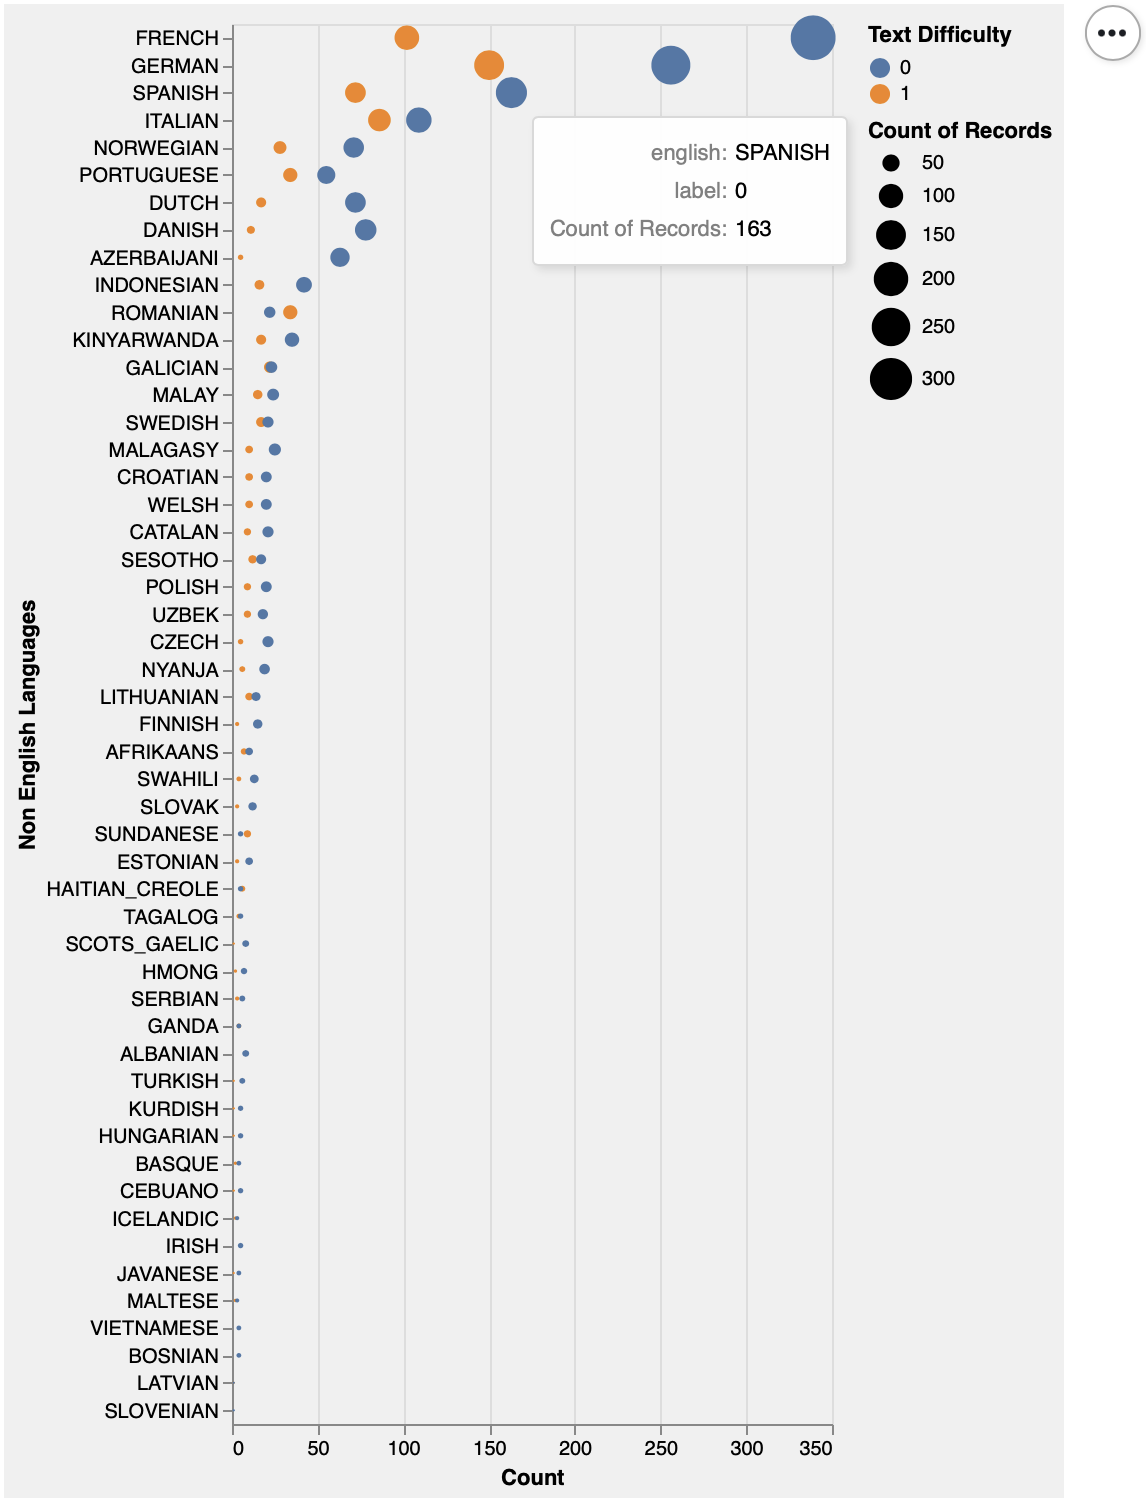

In [34]:
english_unknown_lables = (alt.Chart(df_english_)
                          .mark_bar()
                          .encode(
                              y = alt.Y('count(english):Q', title = 'Count'), 
                              size = alt.Size('count(english):Q', scale=alt.Scale(range = [50,100])),
                              x = alt.X('english:N', title = 'English & Unknown Languages'),
                              color = alt.Color('label:N', legend = alt.Legend(title = 'Text Difficulty')),
                              tooltip = ['english','label', 'count(english):Q'])
                          .transform_filter((alt.datum.english=='ENGLISH')|(alt.datum.english=='Unknown'))
                          .properties(width = 300, height = 600)
                          .configure_view(strokeWidth =0)
                          .configure(background = '#f0f0f0'))

In [35]:
english_unknown_lables

alt.Chart(...)

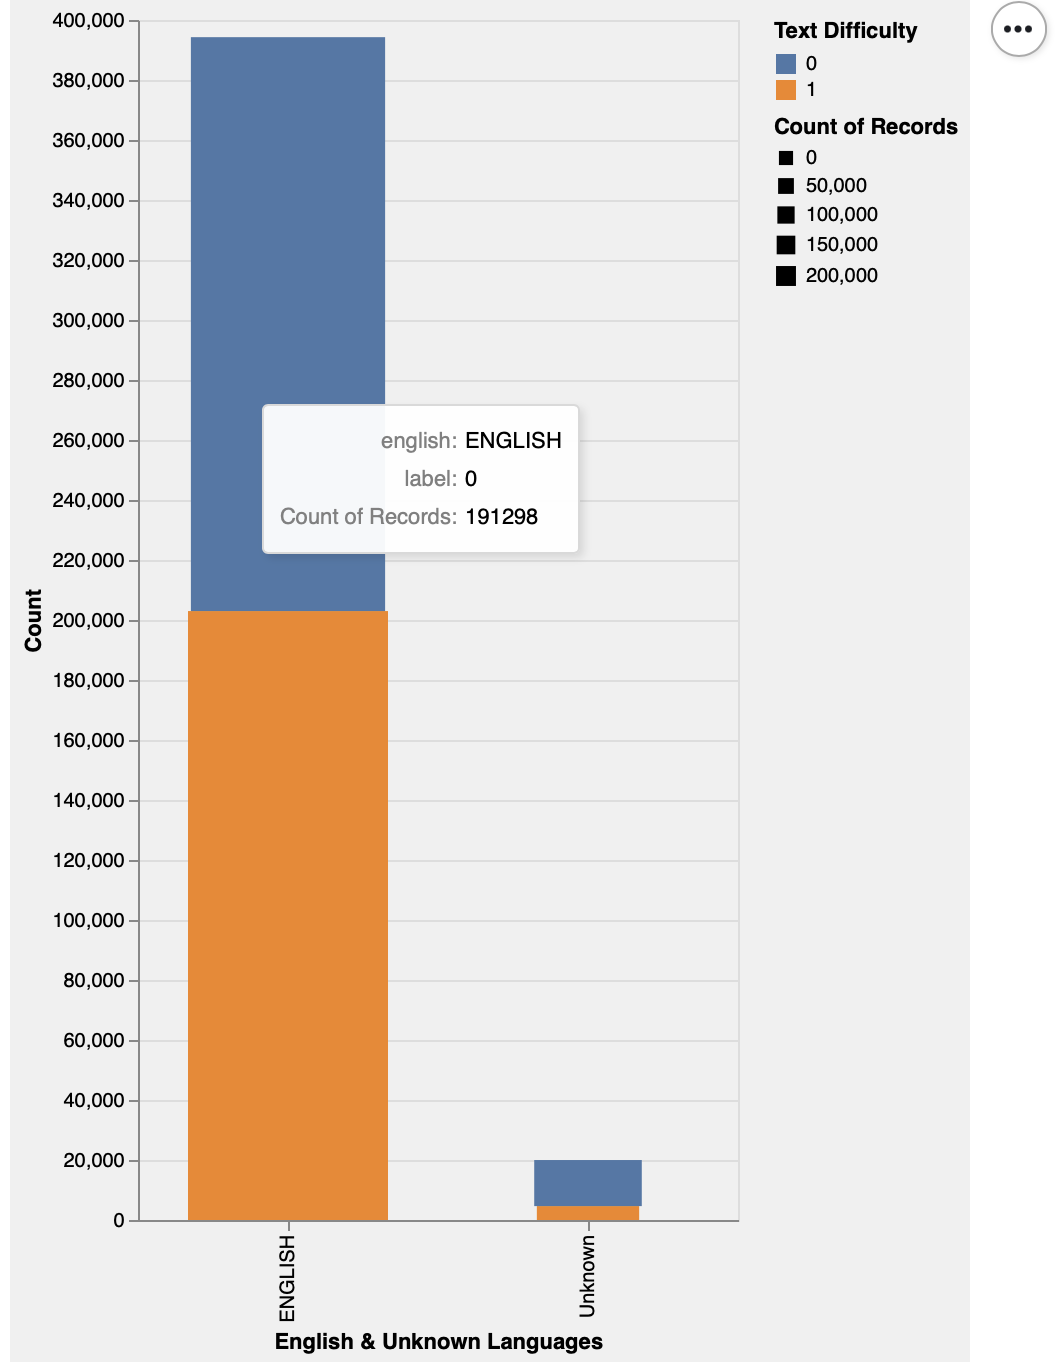